In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_5957/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [14]:
# CODE FOR plotting ens spread in model year 2011 FOR ALL FILES

import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit

@jit()
def rms(true,prediction):
    return np.sqrt(np.nanmean((prediction-true)**2))

@jit()
def rms_tendency(variable,hours):
    variable_tendency = np.zeros((hours))
    variable = np.exp(variable) * 1000.0
    for i in range(hours):
        variable_tendency[i] = np.sqrt(np.mean((variable[i+1] - variable[i])**2.0))
    return variable_tendency

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true
    weights = np.cos(np.deg2rad(lats))
    weights2d = np.zeros(np.shape(diff))
    diff_squared = diff**2.0
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)
    return np.sqrt(weighted_average)

# Define: Initial FILES, dates, Variable, and Level desired

analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/mean.nc'

# analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_cov_1_5_40MEM_individual_ens_member_20110101_20110601/mean_output_gues/out.nc'

## ERA5 crash tests
# analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_28_yr_trained_weights_MEM1_eq_MEM2/mean_output/out.nc'
#analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_crash_ens_members_test/mean_output/out.nc'

analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/TROY_ERA5_RESULTS_TEST2/mean_output/out.nc'


# mean spread
# spread_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/sprd.nc'
# mean spread
# spread_file_hybrid =  '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_3_1_3_20110101_20110529_retry/sprd.nc'

start_year = 2011
end_year = 2011

startdate = datetime(2011,1,1,0)
enddate = datetime(2011,1,9,0)
time_slice = slice(startdate,enddate)

level = 0.95 #0.2#0.95#0.51
level_era = 7 #2#7 #4

var_era = 'V-wind'#'Specific_Humidity'#'Temperature' #'V-wind'
var_da =  'v'#'q'#'t'#'v'
print('you selected for variable =',var_era)
print('at level =',level)
timestep_6hrly = 6


# create empty list to store indiviudal datasets
era5sets = []
print('made it to the for loop...')

# LOAD DATA HERE 
print('LOADING DATA...')

# loop over the range of years and open each ds
for year in range(start_year, end_year + 1):
    nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
    # only load var_era selected and only load level_era selected from above
    ds_nature = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)
    # Read in every 6th timestep
    ds_nature = ds_nature.isel(Timestep=slice(None, None, timestep_6hrly))
    era5sets.append(ds_nature)
    
print('Now its concatinating them all together...')

ds_nature = xr.concat(era5sets, dim = 'Timestep')
ds_nature = ds_nature.sortby('Timestep')
print('Done concat and sortby Timestep...')
temp_500_nature = ds_nature.values

ds_analysis_mean = xr.open_dataset(analysis_file)[var_da].sel(lev=level,time=time_slice)
ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)[var_da].sel(lev=level,time=time_slice)

# SPREAD FILES
# ds_spread_hybrid = xr.open_dataset(spread_file_hybrid)
# ds_spread_speedy = xr.open_dataset(spread_file_speedy)
temp_500_analysis = ds_analysis_mean

# temp_500_analysis = ds_analysis_mean[var_da].sel(lev=level).values
temp_500_analysis_speedy = ds_analysis_mean_speedy
# temp_500_analysis_speedy = ds_analysis_mean_speedy[var_da].sel(lev=level,time=time_slice).values
# temp_500_spread_hybrid = ds_spread_hybrid[var_da].sel(lev=level).values
# temp_500_spread_speedy = ds_spread_speedy[var_da].sel(lev=level).values



print('era5 shape = ',np.shape(temp_500_nature))
print('speedy shape = ',np.shape(temp_500_analysis_speedy))
print('hybrid shape = ',np.shape(temp_500_analysis))

#find smallest index value to set that as the "length"
speedy_index = temp_500_analysis_speedy.shape[0]
nature_index = temp_500_nature.shape[0]
hybrid_index = temp_500_analysis.shape[0]
smallest_index = min(speedy_index,nature_index,hybrid_index)

if smallest_index == speedy_index:
    length = speedy_index #- 1
elif smallest_index == nature_index:
    length = nature_index
else:
    length = hybrid_index
print('the smallest length is',length)

#ps_nature = ds_nature['logp'].values
#ps_nature = 1000.0 * np.exp(ps_nature)
#ps_analysis = ds_analysis_mean['ps'].values/100.0

xgrid = 96
ygrid = 48
#length =365*4*2 #1952-7 # 240 for 3 months  #1450 ##338 #160#64#177#1400#455

analysis_rmse = np.zeros((length))
analysis_rmse_speedy = np.zeros((length))
# global_average_ensemble_spread_hybrid = np.zeros((length))
# global_average_ensemble_spread_speedy = np.zeros((length))
#ps_rmse = np.zeros((length))

analysis_error = np.zeros((length,ygrid,xgrid))
analysis_error_speedy = np.zeros((length,ygrid,xgrid))

print(np.shape(analysis_error))
print(np.shape(analysis_error_speedy))

print('Now its calculating analysis RMSE...')
lats = ds_nature.Lat
for i in range(length):
    analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis[i,:,:],lats)
    analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis_speedy[i,:,:],lats)
    #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
    analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i,:,:]
    analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i,:,:]
#     global_average_ensemble_spread_hybrid[i] = np.average(temp_500_spread_hybrid[i,:,:])
#     global_average_ensemble_spread_speedy[i] = np.average(temp_500_spread_speedy[i,:,:])

# print('mean analysis_rmse = ',analysis_rmse)

print('DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP')
    
# FOR DEALING WITH HOURLY RES ERA5 REANAL (((i*6)))

# for i in range(length):
#     analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i*6,:,:],temp_500_analysis[i,:,:],lats)
#     analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i*6,:,:],temp_500_analysis_speedy[i,:,:],lats)
#     #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
#     analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i*6,:,:]
#     analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i*6,:,:]
#     #global_average_ensemble_spread[i] = np.average(temp_500_spread[i,:,:])
print('Done.')

you selected for variable = V-wind
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (33, 48, 96)
hybrid shape =  (33, 48, 96)
the smallest length is 33
(33, 48, 96)
(33, 48, 96)
Now its calculating analysis RMSE...
DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP
Done.


In [15]:
# LOAD ENS_MEMBERS

# Define the base path for the files
# base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_hybrid_20110101_2011052906/anal'
# base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_28_yr_trained_weights/'

### ERA 5 crash test
base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/TROY_ERA5_RESULTS_TEST2/'

# base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_28_yr_trained_weights_MEM1_eq_MEM2/'


# base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_cov_1_5_40MEM_individual_ens_member_20110101_20110601/'


# Define the variable name, level, and time slice
start_year = 2011
end_year = 2011

# startdate = datetime(2011,1,1,0)
# enddate = datetime(2011,6,1,0)
time_slice = slice(startdate,enddate)

# level = 0.95 #0.2#0.95#0.51
# level_era = 7 #2#7 #4

# var_era = 'Temperature'#'Specific_Humidity'#'Temperature' #'V-wind'
# var_da =  't'#'q'#'t'#'v'
print('you selected for variable =',var_era)
print('at level =',level)

# Create an empty list to store the datasets
ds_list = []

# ens member list
ens_member_list = range(1,40+1)
print("opening all files...")
# Loop through the member numbers and read in the corresponding files
for member_number in ens_member_list:
    file_path = f'{base_path}/{member_number:03d}_output/out.nc'
    # file_path = f'{base_path}/{member_number:03d}_output/{member_number:03d}.nc'
    ds = xr.open_dataset(file_path)[var_da].sel(lev=level, time=time_slice)
    ds_list.append(ds)
print('shape test =', np.shape(ds_list))    
# print('ds_list[0] =',ds_list[0])

# Assign each element in ds_list to be called ds_member_{i}
# for i, ds in enumerate(ds_list, start=1):
#     globals()[f'ds_member_{i}'] = ds
    
# print(ds_member_1) 

lats = ds_nature.Lat

# analysis_error is for maps, see its a 3d array, 
# MAKING analysis_rmse now

print('MAKING zeros arrays..')
quantity_of_ens_members = 40
analysis_rmse_object = np.zeros((quantity_of_ens_members, length))

# check shape, yes they are equal and vibing
# print('new = ',np.shape(analysis_rmse_object[0]))
# print('old = ', np.shape(analysis_rmse_1))

print('looping through each ens_member at every timestep..')
for member_number in range(0,40):
    # loop through each timestep
    for l in range(length):
#     for l in range(length):
        analysis_rmse_object[member_number,l] = latituded_weighted_rmse(temp_500_nature[l,:,:],ds_list[member_number][l,:,:],lats)

##### and calc for mem 1 with length == 3:
# analysis_rmse_mem1 = latituded_weighted_rmse(temp_500_nature[3,:,:],ds_list[1][3,:,:],lats)
# print(analysis_rmse_mem1)
#####

# print('analysis_rmse_object[0] =',analysis_rmse_object[0])
# print('analysis_rmse_object[39] =',analysis_rmse_object[39])    
    
print('Done with analysis.')

# Now Calculate Gues field error compared to ERA5



you selected for variable = V-wind
at level = 0.95
opening all files...
shape test = (40, 33, 48, 96)
MAKING zeros arrays..
looping through each ens_member at every timestep..
Done with analysis.


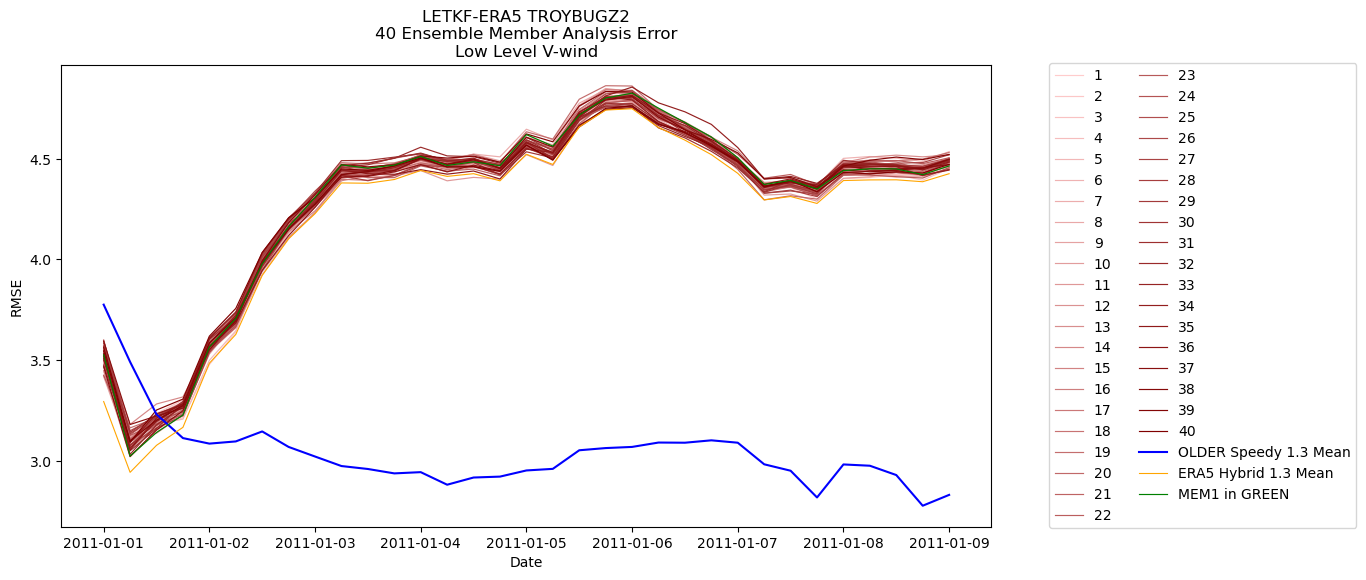

In [16]:
# code for plot every ensemble member

# MAKE TIME SERIES for each ensemble member

x = np.arange(0,length)
base = datetime(2011,1,1,0)

plt.figure(figsize=(12,6))
date_list = [base + timedelta(days=x/4) for x in range(length)]

# make colors for 40 member ens
from matplotlib.colors import LinearSegmentedColormap
start_color = np.array([1.0, 0.8, 0.8])  # Light Red (RGB values)
end_color = np.array([0.5, 0.0, 0.0])   # Dark Red (RGB values)
# Create a colormap with 40 colors by linearly interpolating between start and end colors
cmap = LinearSegmentedColormap.from_list("custom_colormap", np.linspace(start_color, end_color, 40))
# Get a list of 40 different colors from the colormap
num_colors = 40
colors = [cmap(i / (num_colors - 1)) for i in range(num_colors)]

for each_member in range(0,40):
    plt.plot(date_list,analysis_rmse_object[each_member],linewidth=.85,color=colors[each_member],label=each_member+1)
    
plt.plot(date_list,analysis_rmse_speedy,label='OLDER Speedy 1.3 Mean',color='blue')    
plt.plot(date_list,analysis_rmse,label='ERA5 Hybrid 1.3 Mean',linewidth=0.8,color='orange')

plt.plot(date_list,analysis_rmse_object[0],linewidth=.85,color='green',label='MEM1 in GREEN')

plt.title('LETKF-ERA5 TROYBUGZ2\n40 Ensemble Member Analysis Error\nLow Level V-wind')
plt.xlabel('Date')
plt.ylabel('RMSE')
# plt.xlim([datetime(2011,5,25,0),datetime(2011,5,29,12)])
# plt.ylim(1.25,2.75)
plt.legend(ncol=2,loc='center right', bbox_to_anchor=(1.4, 0.5))
plt.show()

In [39]:
# CODE TO DO SAME PLOT BUT PLOT VALUES NOT ERROR
# AND INCLUDE ERA5 DATA

# to need to take create a latituded weighted mean 

# ERA5 values
era5_values = temp_500_nature[0:length,:,:]
# print(np.shape(era5_values))


era5_mean_at_each_timestep = np.mean(era5_values, axis=(1,2))
hybrid_meanateach = np.mean(temp_500_analysis,axis=(1,2))
speedy_meanateach = np.mean(temp_500_analysis_speedy[:-7,:,:],axis=(1,2))
# print(np.shape(era5_mean_at_each_timestep))
# print(era5_mean_at_each_timestep)
# yes worked!

# figure
plt.figure(figsize=(12,6))
date_list = [base + timedelta(days=x/4) for x in range(length)]

# print(np.shape(ds_list[0]))
# print(ds_list[0].values)
# for member in range(0,40):
#     print(np.shape(ds_list[member].values))

# WEST AFRICA GRIDPOINT EXAMPLE

# plt.plot(date_list, temp_500_nature[0:length*6:6,y_WA,x_WA], color = 'g', label = 'ERA5')
# plt.plot(date_list, temp_500_analysis[0:length,y_WA,x_WA], color = 'r', label = 'Hybrid')
# plt.plot(date_list,temp_500_analysis_speedy[0:length,y_WA,x_WA], color = 'b', label = 'SPEEDY') 
# plt.xlim([datetime(2011, 1, 1,0), datetime(2011, 5, 31,0)])
# plt.xlabel('Date')
# plt.ylabel('Specific Humidity')
# plt.title('Low Level Specific Humidity')
# plt.legend()


<Figure size 1200x600 with 0 Axes>

ValueError: x and y must have same first dimension, but have shapes (3,) and (0,)

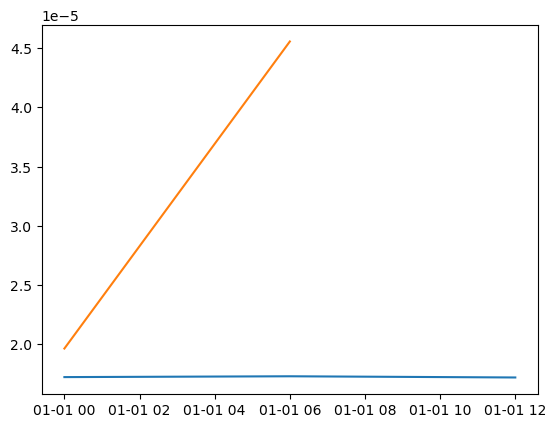

In [40]:
plt.plot(date_list,era5_mean_at_each_timestep)
plt.plot(date_list[:-1],hybrid_meanateach[:-1])
plt.plot(date_list,speedy_meanateach)

<xarray.DataArray 'Lat' (Lat: 48)>
array([-87.159, -83.479, -79.777, -76.07 , -72.362, -68.652, -64.942, -61.232,
       -57.521, -53.81 , -50.099, -46.389, -42.678, -38.967, -35.256, -31.545,
       -27.833, -24.122, -20.411, -16.7  , -12.989,  -9.278,  -5.567,  -1.856,
         1.856,   5.567,   9.278,  12.989,  16.7  ,  20.411,  24.122,  27.833,
        31.545,  35.256,  38.967,  42.678,  46.389,  50.099,  53.81 ,  57.521,
        61.232,  64.942,  68.652,  72.362,  76.07 ,  79.777,  83.479,  87.159],
      dtype=float32)
Coordinates:
  * Lat      (Lat) float32 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
Attributes:
    units:    degrees_east
<xarray.DataArray 'Lat' (Lat: 48)>
array([0.0495645 , 0.11356745, 0.17747983, 0.24073623, 0.30300197,
       0.36403164, 0.42353553, 0.4812642 , 0.53699046, 0.59046483,
       0.64146304, 0.6897586 , 0.73517495, 0.7775083 , 0.81658113,
       0.85222954, 0.8843122 , 0.91267735, 0.93721503, 0.9578225 ,
       0.9744132 , 0.9869177 , 0.9952

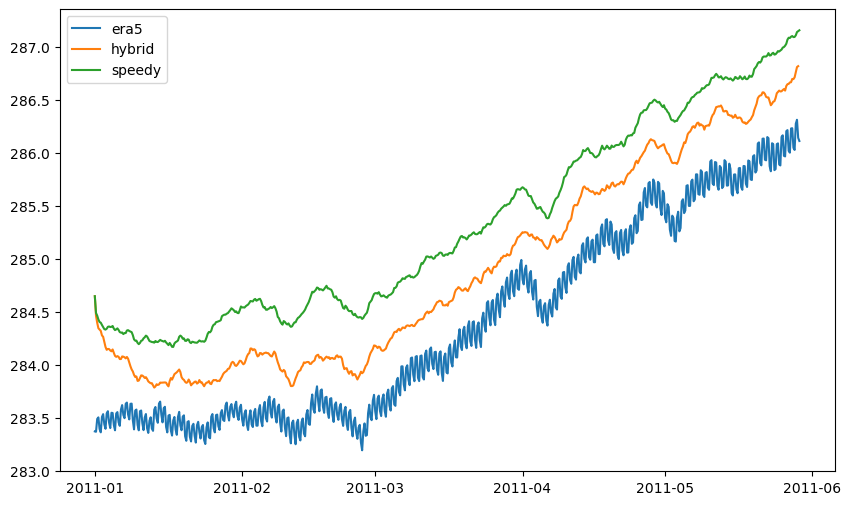

In [6]:
# original rmse calculation

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true
    weights = np.cos(np.deg2rad(lats))
    weights2d = np.zeros(np.shape(diff))
    diff_squared = diff**2.0
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)
    return np.sqrt(weighted_average)

# My Version: reword for no diff - only one input
def latituded_weighted_values_test_yo(data,lats):
#     diff = true
    weights = np.cos(np.deg2rad(lats))
    weights2d = np.zeros(np.shape(data))
#     diff_squared = diff
    data_squared = data**2
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
    masked = np.ma.MaskedArray(data_squared, mask=np.isnan(data_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)
    return np.sqrt(weighted_average)

##### PRINTING STYLE
def latituded_weighted_values_testprint_yo(data,lats):
#     diff = true
    print(lats)
    weights = np.cos(np.deg2rad(lats))
    print(weights)
    weights2d = np.zeros(np.shape(data))
    print('weights2d np zeros.. ',weights2d)
#     diff_squared = diff
    data_squared = data**2
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    print('np tile weights2d =',weights2d)
    weights2d = np.transpose(weights2d)
    print('transpose =', weights2d)
    masked = np.ma.MaskedArray(data, mask=np.isnan(data))
    print('masked =', masked)
    weighted_average = np.ma.average(masked,weights=weights2d)
    
    return weighted_average
test1 = latituded_weighted_values_testprint_yo(era5_values[0,:,:],lats)

print(test1)

analysis_values_era5 = np.zeros((length))
analysis_values_hybrid = np.zeros((length))
analysis_values_speedy = np.zeros((length))

for i in range(length):
    analysis_values_era5[i] = latituded_weighted_values_test_yo(era5_values[i,:,:],lats)
    analysis_values_hybrid[i] = latituded_weighted_values_test_yo(temp_500_analysis[i,:,:],lats)
    analysis_values_speedy[i] = latituded_weighted_values_test_yo(temp_500_analysis_speedy[i,:,:],lats)

plt.figure(figsize=(10,6))
plt.plot(date_list,analysis_values_era5,label='era5')
plt.plot(date_list[:-1],analysis_values_hybrid[:-1],label='hybrid')
plt.plot(date_list,analysis_values_speedy,label='speedy')
plt.legend()

In [7]:
print(np.shape(analysis_values_era5))
print(np.shape(analysis_values_hybrid))
print(np.shape(analysis_values_speedy))

(594,)
(594,)
(594,)


Text(0.5, 1.0, 'LETKF Analysis Values\nLow Level Temperature')

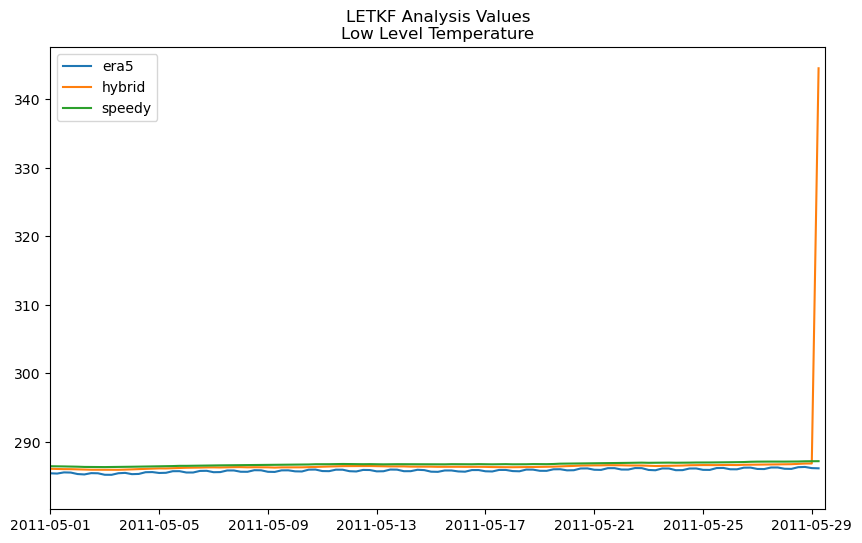

In [8]:
plt.figure(figsize=(10,6))
plt.plot(date_list,analysis_values_era5,label='era5')
plt.plot(date_list,analysis_values_hybrid,label='hybrid')
plt.plot(date_list,analysis_values_speedy,label='speedy')
plt.xlim([datetime(2011,5,1,0),datetime(2011,5,29,12)])
plt.legend()
plt.title('LETKF Analysis Values\nLow Level Temperature')